In [110]:
import scipy
import json
import os

import pandas as pd
import seaborn as sns
import scipy.stats

import matplotlib.pyplot as plt

In [ ]:
# def load_single_attack_results(
#     scenario: str,
#     version: str,
#     dataset: str
# ):
#     '''Loads json file (attack results) and csv files (Shapley, LOO, Alpha)
#     into a one pandas dataframe'''
    
#     ## Loads the json file with atack metrics
#     metrics = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Advantage', 'AUC']
#     json_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'nodes_attack_results.json')
#     with open(json_path, 'r+') as file:
#         json_file = json.load(file)
#     clients_ids = [int(i) for i in json_file.keys() if i != 'average']
#     iterations = [int(i) for i in json_file['0'].keys()]
#     iterations.sort()
#     headings = [f'{client}_{metric}' for client in clients_ids for metric in metrics]
    
#     dataframe = pd.DataFrame(index=iterations, columns=headings)
    
#     for client in clients_ids:
#         for iteration in iterations:
#             client_data = json_file[str(client)][str(iteration)]['average']
#             for heading in metrics:
#                 dataframe.loc[iteration, f"{client}_{heading}"] = client_data[heading]
    
#     ## 
#     return dataframe

In [83]:
def load_single_contribution_attack_results(
    scenario: str,
    version: str,
    dataset: str
):
    '''Loads json file (attack results) and csv files (Shapley, LOO, Alpha)
    into a one pandas dataframe'''
    
    ## Loads the json file with atack metrics
    metrics = ['TPR', 'AUC']
    json_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'nodes_attack_results.json')
    shapley_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_shapley.csv')
    loo_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_loo.csv')
    with open(json_path, 'r+') as file:
        json_file = json.load(file)
    clients_ids = [int(i) for i in json_file.keys() if i != 'average']
    iterations = [int(i) for i in json_file['0'].keys()]
    iterations.sort()
    headings = [f'{client}_{metric}' for client in clients_ids for metric in metrics]
    
    dataframe = pd.DataFrame(index=iterations, columns=headings)
    
    # Loads attack results into the frame
    for client in clients_ids:
        for iteration in iterations:
            client_data = json_file[str(client)][str(iteration)]['average']
            for heading in metrics:
                dataframe.loc[iteration, f"{client}_{heading}"] = client_data[heading]
    
    # Loads shapley into the frame
    shapley_frame = pd.read_csv(shapley_path)
    loo_frame = pd.read_csv(loo_path)
    for client in clients_ids:
        # Loads shapley values
        array = shapley_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_ACC'] = array
        array = shapley_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_F1SCORE'] = array
        
        # Loads LOO values
        array = loo_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_LOO_ACC'] = array
        array = loo_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_LOO_F1SCORE'] = array
    
    return dataframe

In [90]:
def load_multiple_contribution_attack_results(
    scenarios: list[str],
    versions: list[str],
    datasets: list[str]
):
    all_results = {
        f"{scenario}_{version}_{dataset}" : None
        for scenario in scenarios
        for version in versions
        for dataset in datasets
    }
    for scenario in scenarios:
        for version in versions:
            for dataset in datasets:
                key = f"{scenario}_{version}_{dataset}"
                all_results[key] = load_single_contribution_attack_results(
                    scenario=scenario,
                    version=version,
                    dataset=dataset
                    )
    return all_results

In [128]:
def calculate_single_pearson_corr(
    no_clients: int,
    frame: pd.DataFrame
):
    pearson_corr = pd.DataFrame(index=range(no_clients))
    for client in range(no_clients):
        pearson_corr.loc[client, 'TPR_TO_SHAP_ACC'] = scipy.stats.pearsonr(
            x=frame[f'{client}_TPR'],
            y=frame[f'{client}_SHAP_ACC']
        ).statistic
        pearson_corr.loc[client, 'AUC_TO_SHAP_ACC'] = scipy.stats.pearsonr(
            x=frame[f'{client}_AUC'],
            y=frame[f'{client}_SHAP_ACC']
        ).statistic
        pearson_corr.loc[client, 'TPR_TO_SHAP_F1SCORE'] = scipy.stats.pearsonr(
            x=frame[f'{client}_TPR'],
            y=frame[f'{client}_SHAP_F1SCORE']
        ).statistic
        pearson_corr.loc[client, 'AUC_TO_SHAP_F1SCORE'] = scipy.stats.pearsonr(
            x=frame[f'{client}_AUC'],
            y=frame[f'{client}_SHAP_F1SCORE']
        ).statistic
        
        pearson_corr.loc[client, 'TPR_TO_LOO_ACC'] = scipy.stats.pearsonr(
            x=frame[f'{client}_TPR'],
            y=frame[f'{client}_LOO_ACC']
        ).statistic
        pearson_corr.loc[client, 'AUC_TO_LOO_ACC'] = scipy.stats.pearsonr(
            x=frame[f'{client}_AUC'],
            y=frame[f'{client}_LOO_ACC']
        ).statistic
        pearson_corr.loc[client, 'TPR_TO_LOO_F1SCORE'] = scipy.stats.pearsonr(
            x=frame[f'{client}_TPR'],
            y=frame[f'{client}_LOO_F1SCORE']
        ).statistic
        pearson_corr.loc[client, 'AUC_TO_LOO_F1SCORE'] = scipy.stats.pearsonr(
            x=frame[f'{client}_AUC'],
            y=frame[f'{client}_LOO_F1SCORE']
        ).statistic
    return pearson_corr

In [129]:
def calculate_multiple_pearson_corr(
    results:dict
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_pearson_corr(frame=frame, no_clients=5)
    return all_results

In [ ]:
# def load_single_attack_results_short(
#     scenario: str,
#     version: str,
#     dataset: str
# ):
#     '''Loads json file (attack results) and csv files (Shapley, LOO, Alpha)
#     into a one pandas dataframe'''
    
#     ## Loads the json file with atack metrics
#     metrics = ['TPR', 'AUC']
#     json_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'nodes_attack_results.json')
#     with open(json_path, 'r+') as file:
#         json_file = json.load(file)
#     clients_ids = [int(i) for i in json_file.keys() if i != 'average']
#     iterations = [int(i) for i in json_file['0'].keys()]
#     iterations.sort()
#     headings = [f'{client}_{metric}' for client in clients_ids for metric in metrics]
    
#     dataframe = pd.DataFrame(index=iterations, columns=headings)
    
#     for client in clients_ids:
#         for iteration in iterations:
#             client_data = json_file[str(client)][str(iteration)]['average']
#             for heading in metrics:
#                 dataframe.loc[iteration, f"{client}_{heading}"] = client_data[heading]
    
#     dataframe = dataframe.iloc[-10:].mean()
#     return dataframe

In [ ]:
# def load_all_attack_results_short(
#     scenarios: list[str],
#     versions: list[str],
#     datasets: list[str]
# ):
#     '''Loads json file (attack results) and csv files (Shapley, LOO, Alpha)
#     into a one pandas dataframe'''
    
#     metrics = ['TPR', 'AUC']
#     mapping_dict = {
#         "hs":"highly_skewed",
#         "ls":"lightly_skewed",
#         "uniform":"uniform"
#     }
#     rows = [f"{scenario}_{version}_{dataset}" for scenario in scenarios for version in versions for dataset in datasets]
#     columns = [f'{node}_{metric}' for node in range(8) for metric in metrics]
#     all_dataframe = pd.DataFrame(index=rows, columns=columns)
    
#     for scenario in scenarios:
#         for version in versions:
#             for dataset in datasets:
#                 # Defining Paths
#                 json_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'nodes_attack_results.json')
#                 shapley_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'full_shapley.csv')
#                 loo_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'full_loo.csv')
#                 alpha_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'full_alpha.csv')
#                 # Opening Files
#                 with open(json_path, 'r+') as file:
#                     json_file = json.load(file)
#                 shapley_frame, loo_frame, alpha_frame = pd.read_csv(shapley_path), pd.read_csv(loo_path), pd.read_csv(alpha_path)
                
#                 # Defining number of itertions and number of clients
#                 clients_ids = [int(i) for i in json_file.keys() if i != 'average']
#                 iterations = [int(i) for i in json_file['0'].keys()]
#                 iterations.sort()
#                 headings = [f'{client}_{metric}' for client in clients_ids for metric in metrics]
                
#                 # Populating DataFrame
#                 dataframe = pd.DataFrame(index=iterations, columns=headings)
#                 for client in clients_ids:
#                     for iteration in iterations:
#                         client_data = json_file[str(client)][str(iteration)]['average']
#                         for heading in metrics:
#                             dataframe.loc[iteration, f"{client}_{heading}"] = client_data[heading]

#                 # Inserting summary statistics into the final dataframe
#                 all_dataframe.loc[f"{scenario}_{version}_{dataset}", :] = dataframe.iloc[-10:].mean()
#                 for client in clients_ids:
#                     shapley_score = shapley_frame[shapley_frame['node_id'] == client]
#                     loo_score = loo_frame[loo_frame['node_id'] == client]
#                     #alpha_score = alpha_frame[alpha_frame['node_id'] == client]
#                     all_dataframe.loc[f"{scenario}_{version}_{dataset}", f"{client}_ACC_SHAP"] = shapley_score['accuracy'][client]
#                     all_dataframe.loc[f"{scenario}_{version}_{dataset}", f"{client}_ACC_LOO"] = loo_score['accuracy'][client]
                
#     return all_dataframe

In [105]:
frame = load_single_contribution_attack_results(
    scenario='uniform',
    version='without_DP',
    dataset='mnist'
)

In [70]:
frame

,0_TPR,0_AUC,1_TPR,1_AUC,2_TPR,2_AUC,3_TPR,3_AUC,4_TPR,4_AUC,...,5_LOO_ACC,5_LOO_F1SCORE,6_SHAP_ACC,6_SHAP_F1SCORE,6_LOO_ACC,6_LOO_F1SCORE,7_SHAP_ACC,7_SHAP_F1SCORE,7_LOO_ACC,7_LOO_F1SCORE
0,0.56085,0.612681,0.436506,0.51481,0.606274,0.627728,0.623508,0.652073,0.594778,0.613928,...,-0.0129,-0.022132,-0.078600,-0.084903,-0.0464,-6.303209e-02,-0.070731,-0.073569,-0.0346,-0.052947
1,0.785981,0.731813,0.65845,0.671068,0.805847,0.735531,0.803987,0.733634,0.787858,0.723002,...,-0.0024,-0.001927,-0.005055,-0.004768,-0.0006,-7.278335e-04,0.002106,0.002532,0.0038,0.004336
2,0.862781,0.774557,0.855622,0.753109,0.853996,0.760387,0.879391,0.771694,0.85754,0.748112,...,0.0015,0.001515,-0.000901,-0.000642,-0.0011,-9.492902e-04,0.002844,0.002842,0.0014,0.001358
3,0.897236,0.794543,0.905118,0.776802,0.921808,0.777343,0.912645,0.786433,0.903986,0.781368,...,0.0065,0.007075,0.010935,0.011113,0.0274,2.791403e-02,-0.003580,-0.003843,0.0091,0.009456
4,0.921255,0.79386,0.912049,0.774903,0.931951,0.78681,0.928679,0.794113,0.849412,0.735057,...,0.0015,0.001496,0.003848,0.003791,0.0036,3.482114e-03,-0.001217,-0.001059,-0.0014,-0.001296
5,0.925352,0.788036,0.938303,0.787174,0.946454,0.797186,0.938696,0.795005,0.937392,0.79739,...,0.0016,0.001610,0.001942,0.001947,0.0018,1.789926e-03,0.000077,0.000180,0.0005,0.000555
6,0.942732,0.790844,0.947506,0.794451,0.957075,0.810945,0.927547,0.782139,0.942312,0.805351,...,-0.0006,-0.000607,0.001327,0.001387,0.0004,4.431968e-04,0.001365,0.001374,0.0007,0.000718
7,0.951282,0.807453,0.944176,0.794358,0.95857,0.798894,0.958293,0.798331,0.954897,0.797784,...,0.0007,0.000731,0.003515,0.003512,0.0039,3.912256e-03,-0.000438,-0.000435,0.0001,0.000126
8,0.957215,0.802396,0.953387,0.788511,0.966755,0.797745,0.962587,0.814894,0.951001,0.794668,...,0.0004,0.000408,0.002235,0.002240,0.0020,1.977935e-03,-0.000368,-0.000351,-0.0002,-0.000180
9,0.961827,0.809878,0.957984,0.797309,0.971627,0.803848,0.96711,0.807163,0.961882,0.808689,...,0.0002,0.000190,-0.000243,-0.000211,-0.0009,-8.946350e-04,0.000367,0.000366,0.0000,0.000002


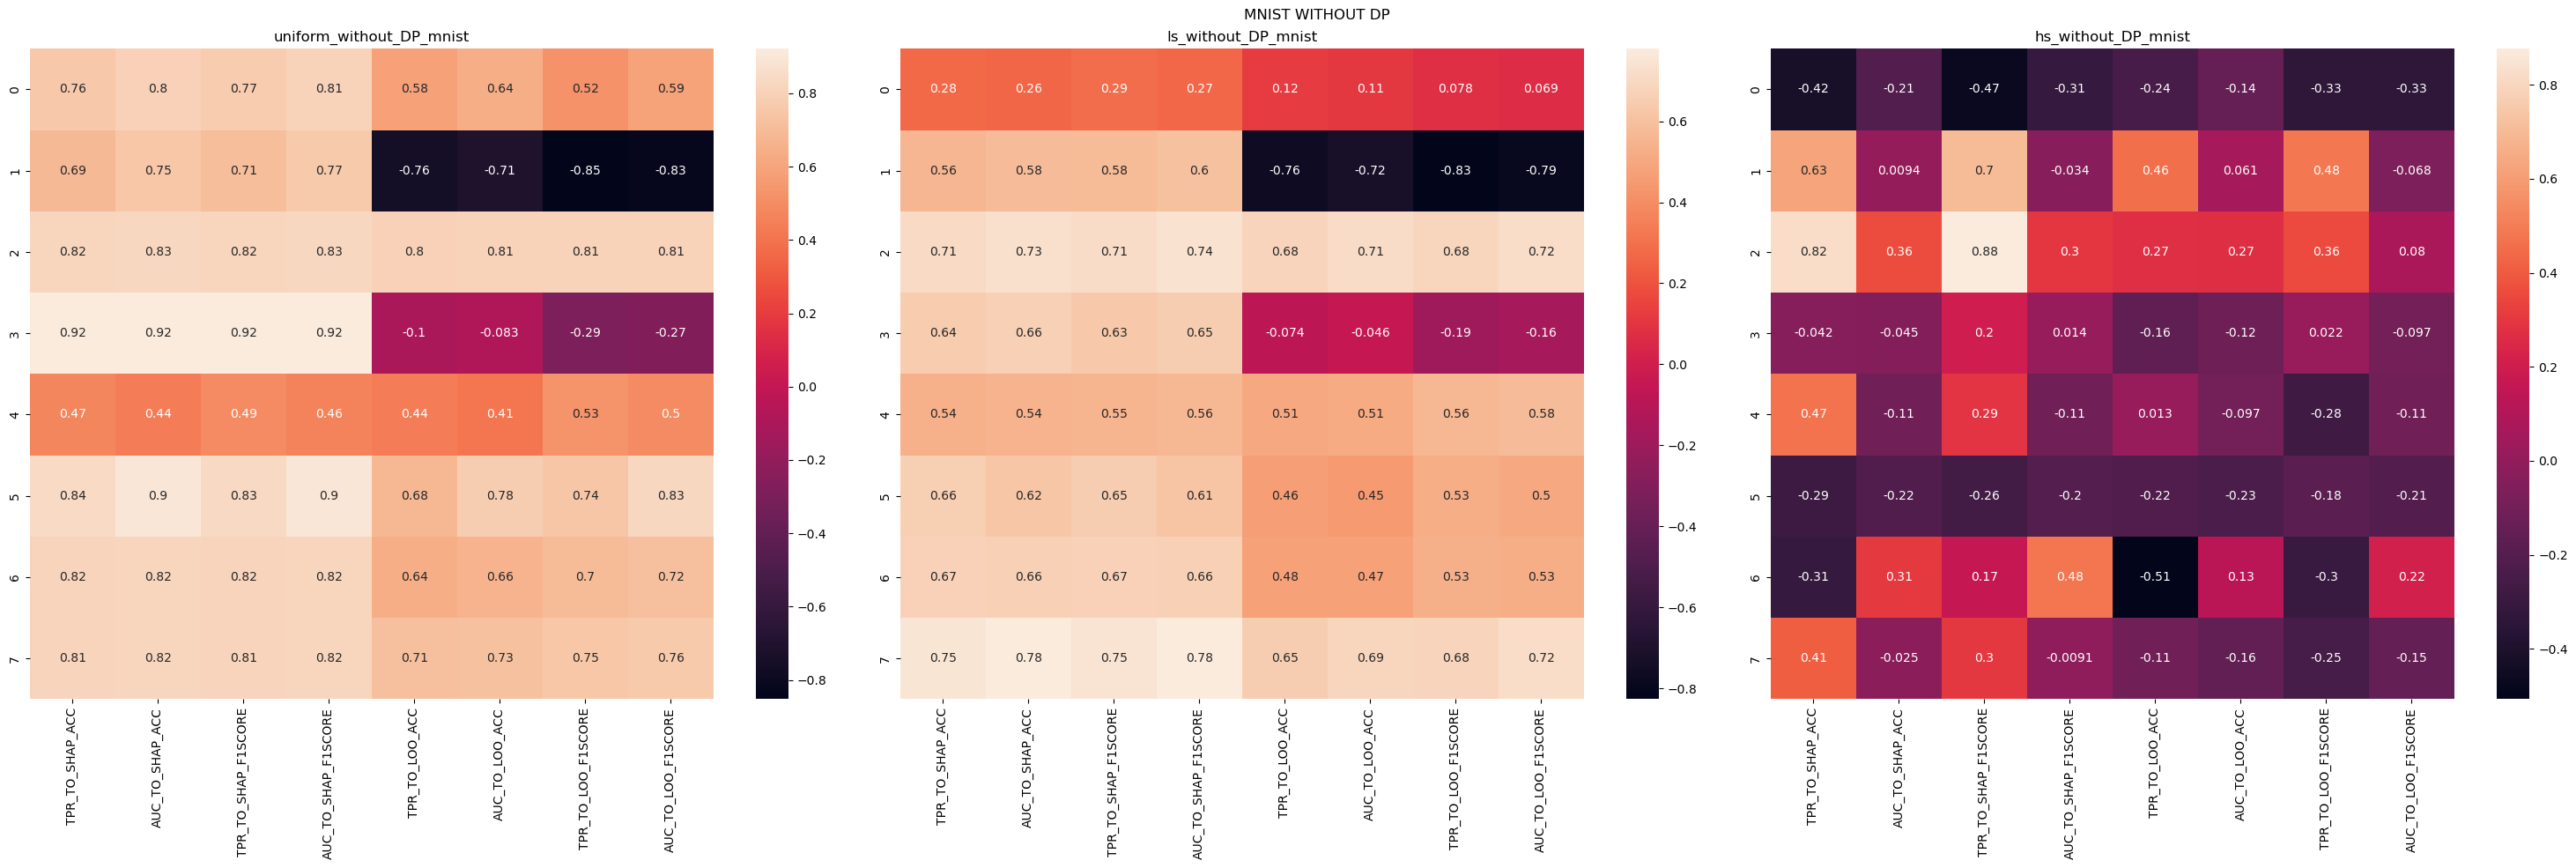

In [126]:
datasets = ['mnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP']
results = load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)
results_pearsonr = calculate_multiple_pearson_corr(results=results)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
for (key, item), ax in zip(results_pearsonr.items(), axes.flatten()):
    sns.heatmap(item, ax=ax, annot=True)
    ax.set_title(key)
fig.suptitle("MNIST WITHOUT DP")
fig.tight_layout()

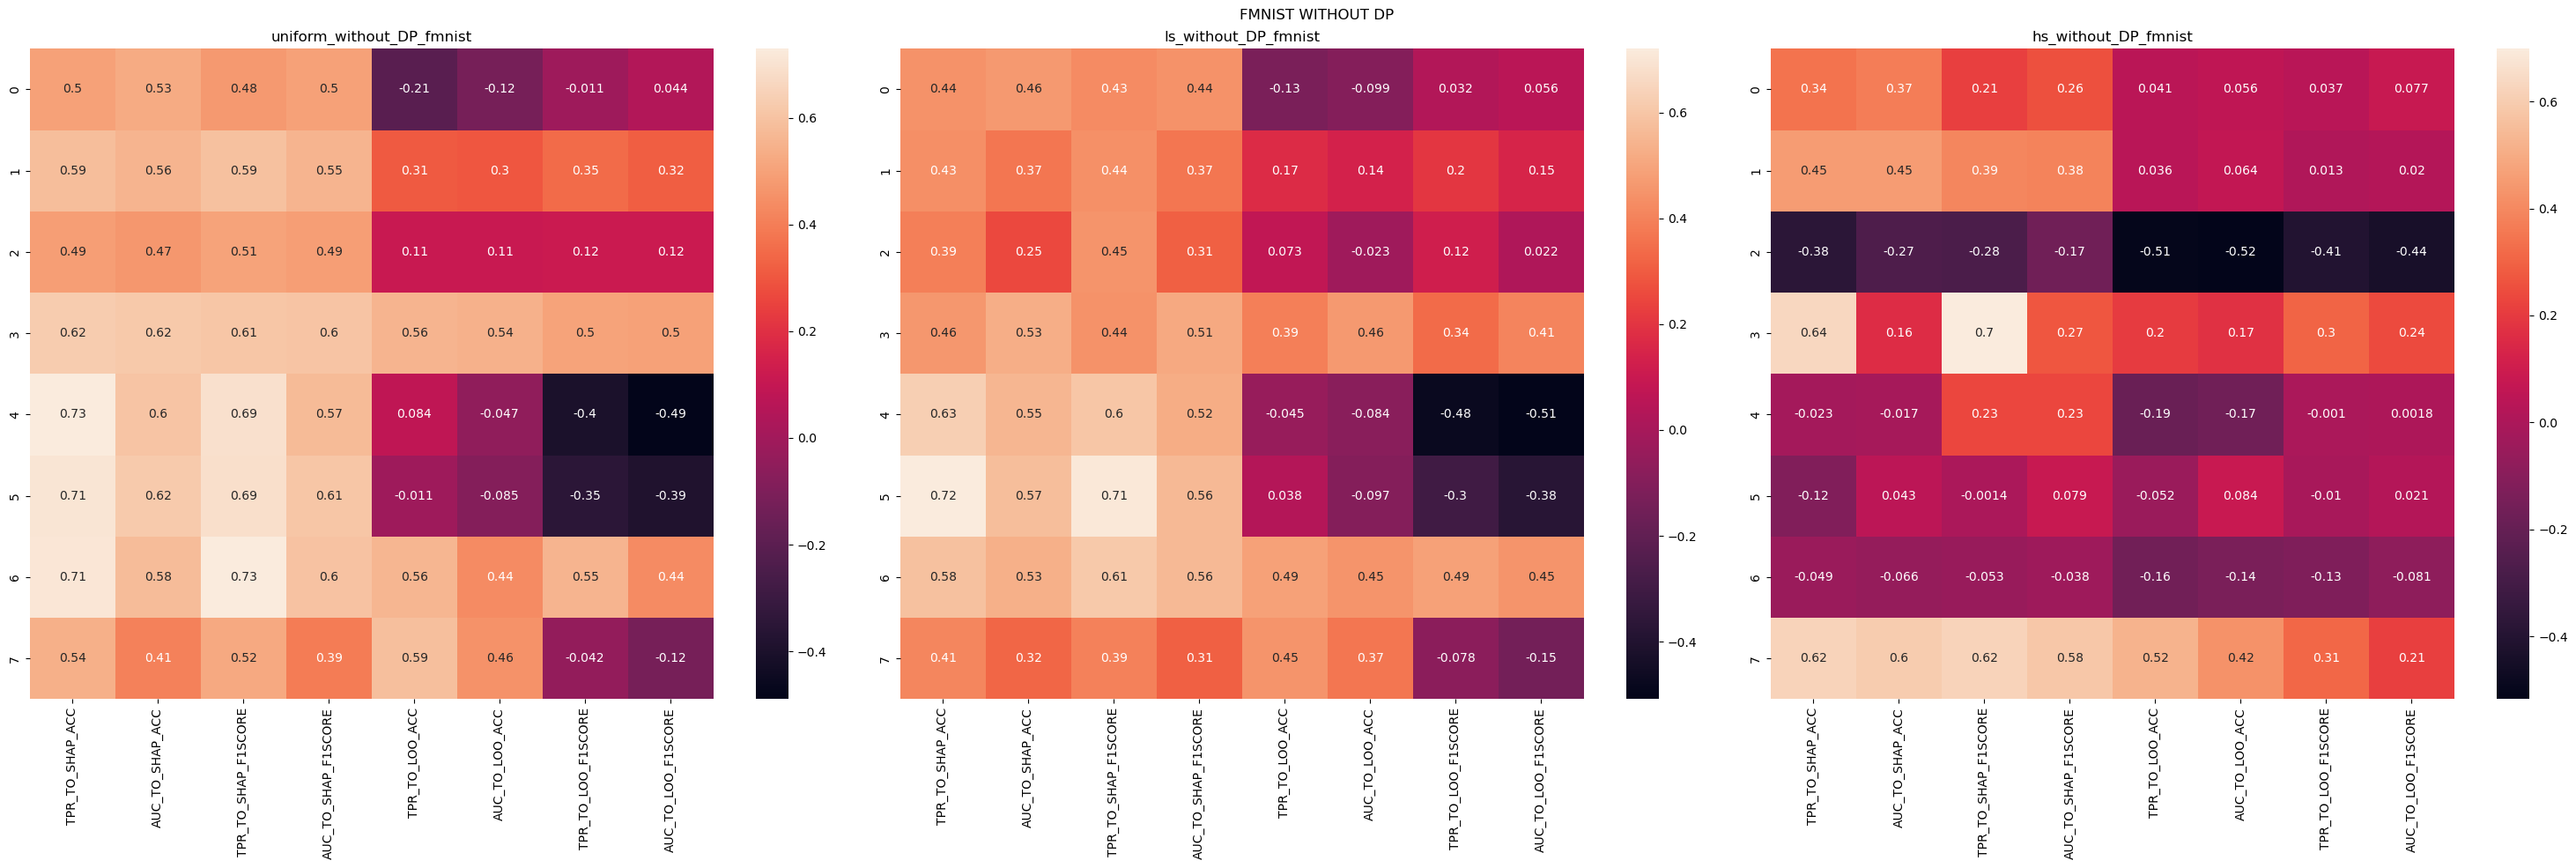

In [127]:
datasets = ['fmnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP']
results = load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)
results_pearsonr = calculate_multiple_pearson_corr(results=results)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
for (key, item), ax in zip(results_pearsonr.items(), axes.flatten()):
    sns.heatmap(item, ax=ax, annot=True)
    ax.set_title(key)
fig.suptitle("FMNIST WITHOUT DP")
fig.tight_layout()

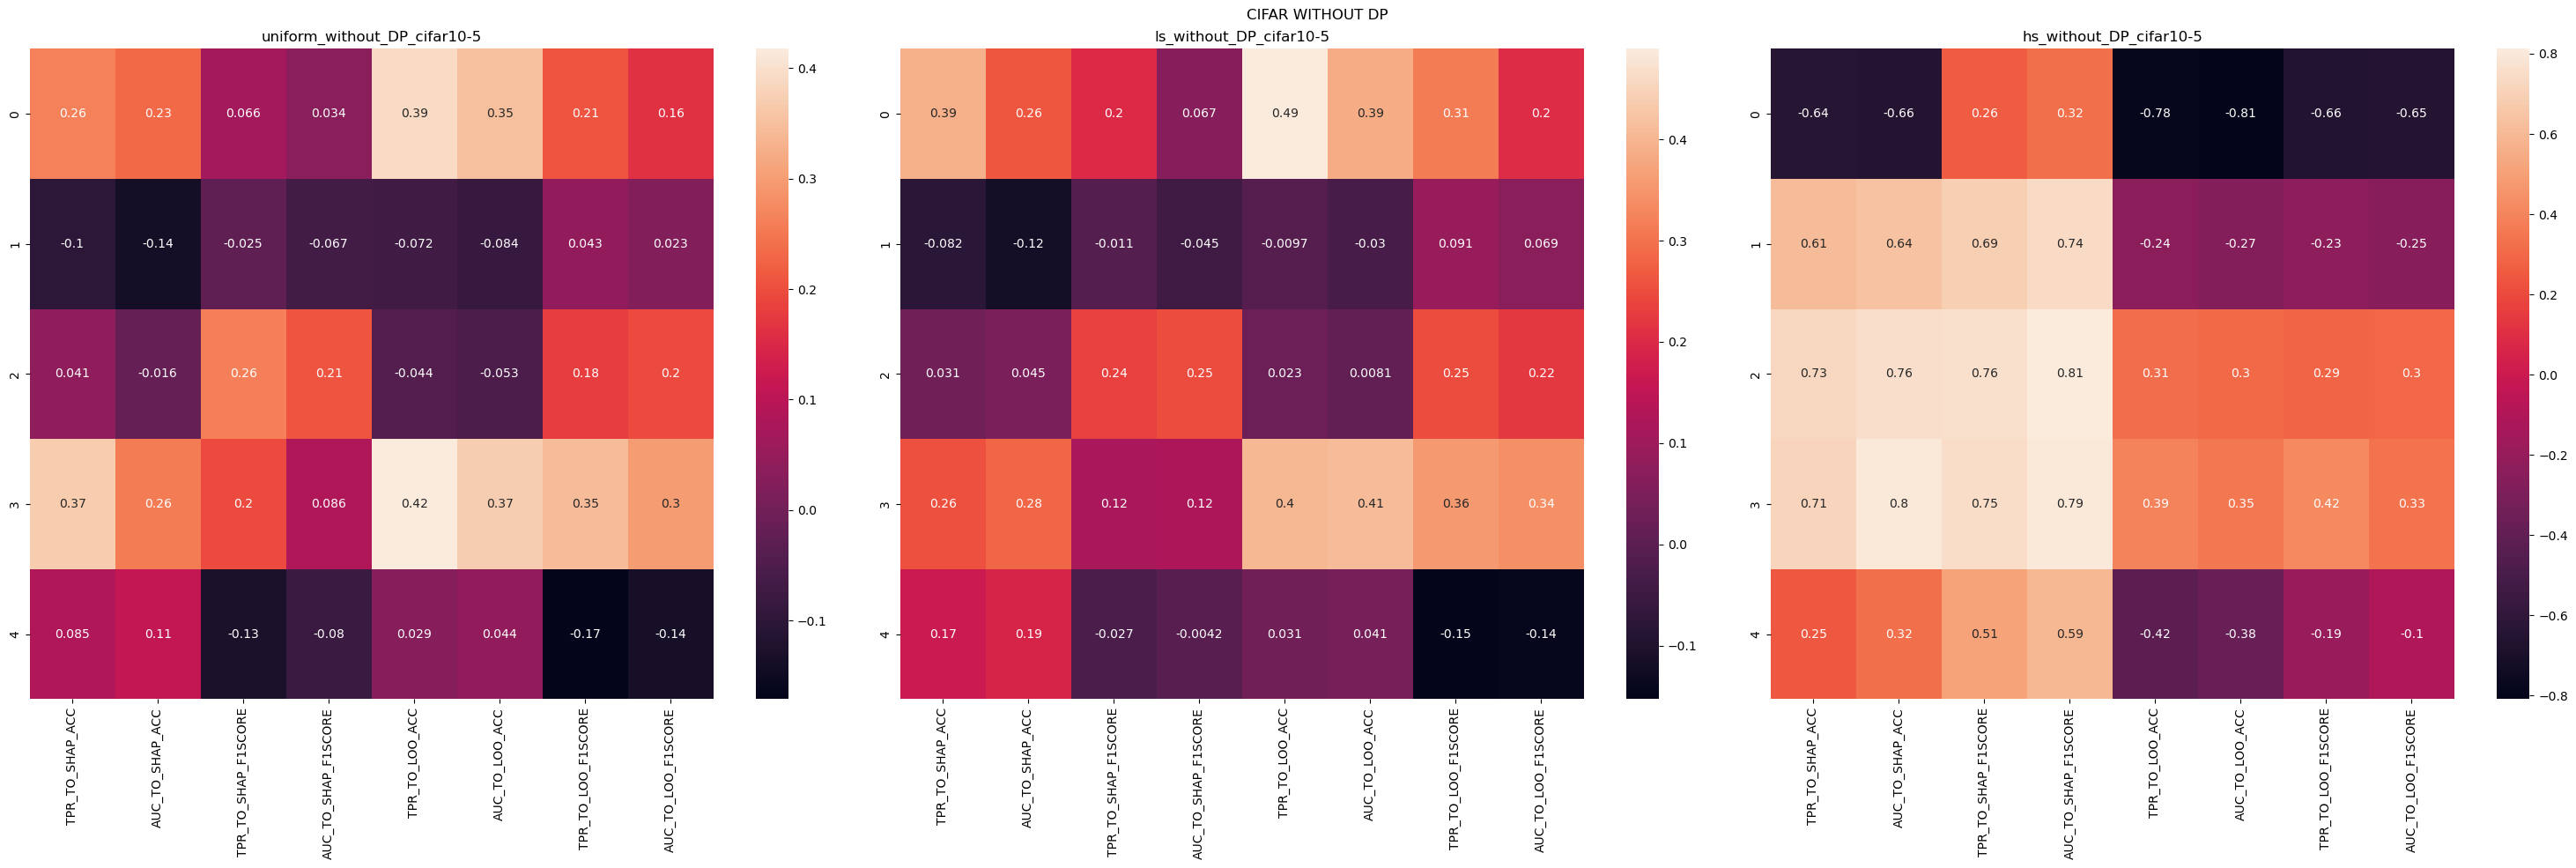

In [131]:
datasets = ['cifar10-5']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP']
results = load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)
results_pearsonr = calculate_multiple_pearson_corr(results=results)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
for (key, item), ax in zip(results_pearsonr.items(), axes.flatten()):
    sns.heatmap(item, ax=ax, annot=True)
    ax.set_title(key)
fig.suptitle("CIFAR WITHOUT DP")
fig.tight_layout()